<h1>Potato Disease Prediction</h1>

**Potato Disease Prediction**
This project is a Potato Disease Prediction System using Deep Learning and Convolutional Neural Networks (CNNs). The model is trained on the PlantVillage dataset and classifies potato leaf images into three categories:

- Potato Early Blight
- Potato Late Blight
- Healthy Leaf

> **Libraries**

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import models, layers
import numpy as np
import matplotlib.pyplot as plt
import os
import pathlib

2025-09-26 23:44:21.072098: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758930261.270973      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758930261.323144      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# importing dataset
dir = os.listdir('../input/plant-village/PlantVillage')
for filenames in dir:
    print(filenames)

Pepper__bell___Bacterial_spot
Potato___healthy
Tomato_Leaf_Mold
Tomato__Tomato_YellowLeaf__Curl_Virus
Tomato_Bacterial_spot
Tomato_Septoria_leaf_spot
Tomato_healthy
Tomato_Spider_mites_Two_spotted_spider_mite
Tomato_Early_blight
Tomato__Target_Spot
Pepper__bell___healthy
Potato___Late_blight
Tomato_Late_blight
Potato___Early_blight
Tomato__Tomato_mosaic_virus


In [3]:
!cp -rf ../input/plant-village/PlantVillage/Potato___Early_blight ./Potato___Early_blight
!cp -rf ../input/plant-village/PlantVillage/Potato___Late_blight ./Potato___Late_blight
!cp -rf ../input/plant-village/PlantVillage/Potato___healthy ./Potato___healthy

In [4]:
Current_Dir = os.getcwd()
dataset_dir = pathlib.Path(Current_Dir)
print(dataset_dir)

/kaggle/working


In [5]:
IMG_SIZE = 256 # image size
BATCH_SIZE = 32 # batch size
CHANNELS = 3
EPOCHS = 50

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    shuffle=True,
    image_size = IMG_SIZE,
    batch_size = BATCH_SIZE,
)
dataset

Found 2152 files belonging to 3 classes.


I0000 00:00:1758930288.599259      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [6]:
print(len(dataset))

class_names = dataset.class_names
print(class_names)

68
['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


> **Some Random Images Shows**

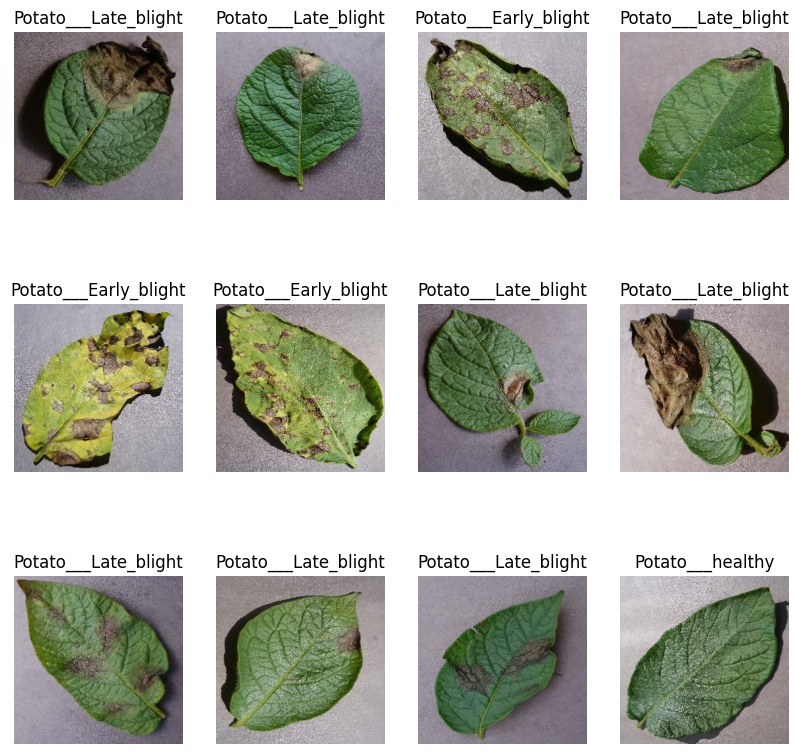

In [7]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
  for i in range(12):
    plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype('uint8'))
    plt.title(class_names[label_batch[i]])
    plt.axis('off')

In [8]:
# 80% data ====> Training
# 10% data ====> Validation
# 10% data ====> Testing

> **Splitting Data**

In [9]:
def splitting_data(ds, train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size=10000):

  if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)
  ds_size = len(ds)
  train_size = int(train_split*ds_size)
  val_size = int(val_split*ds_size)

  train_ds = ds.take(train_size)
  val_ds = ds.skip(train_size).take(val_size)
  test_ds = ds.skip(train_size).skip(val_size)


  return train_ds, val_ds, test_ds


In [10]:
train_ds, val_ds, test_ds = splitting_data(dataset)
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

54
6
8


In [11]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE )
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE )
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE )

> **Data Resizing & Scaling**

In [12]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMG_SIZE, IMG_SIZE),
    layers.Rescaling(1.0/255)
])

> **Data Augmentation**

In [13]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal_and_vertical'),
    layers.RandomRotation(0.2)
])

> **Build Neural Networks**

In [14]:
input_shape = (BATCH_SIZE, IMG_SIZE, IMG_SIZE, CHANNELS)
n_classes = 3
model = tf.keras.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation = 'relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])
model.build(input_shape = input_shape)
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

**Explain the Model Architecture**
> **1. Conv2D**

- This is a 2D convolution layer, commonly used for images.
- It applies small filters (also called kernels) to the image to detect patterns (edges, textures, shapes).
<hr>

> **2. 32**

- This means the layer has 32 filters.
- Each filter learns a different pattern (for example: vertical edges,  horizontal edges, circles, etc.).
- Output feature map depth will be 32 channels.
<hr>

> **3. (3,3)**

- This is the filter size (kernel size).
- A 3×3 filter looks at a small region of the image at a time.
- Smaller kernels (like 3×3) are good at detecting fine details, while larger ones (like 5×5, 7×7) detect broader patterns.
<hr>


> **4. activation='relu'**

- Activation function applied after convolution.
- ReLU (Rectified Linear Unit) sets all negative values to 0, keeping only positive signals.
- Helps the network learn nonlinear features and prevents gradient vanishing.
<hr>


> **5. input_shape=(IMG_SIZE, IMG_SIZE)**

- Defines the input image size for the first layer in the model.
- Important: If your images are RGB (color images), you must add the channel dimension → (IMG_SIZE, IMG_SIZE, 3)
- (height, width, channels)
- 3 = Red, Green, Blue.
<hr>




> **1. What is MaxPooling?**

- Pooling reduces the spatial size (height and width) of the feature maps.
- Instead of looking at every pixel, it summarizes a region.
- With MaxPooling, it takes the maximum value in each region.
<hr>


> **2. (2,2)**

- This is the pool size → a window of 2×2.
- The layer looks at each 2×2 block of the feature map and keeps only the largest value.
- By default, stride = pool size (2), so the feature map shrinks by half in height and width.
<hr>



**Example**

Suppose we have a small 4×4 feature map:

    [1, 3, 2, 4]
    [5, 6, 1, 2]
    [3, 2, 8, 7]
    [4, 1, 9, 5]
- *Apply MaxPooling (2×2):*
- Top-left block → max(1,3,5,6) = 6
- Top-right block → max(2,4,1,2) = 4
- Bottom-left block → max(3,2,4,1) = 4
- Bottom-right block → max(8,7,9,5) = 9

*Result (2×2):*

    [6, 4]
    [4, 9]

<hr>



**Flatten()** → convert CNN features into a long vector.<br>
**Dense(64, relu)** → learn complex feature combinations.<br>
**Dense(n_classes, softmax)** → output final class probabilities.<br>
**model.build(input_shape=...)** → tell Keras what shape of data to expect.

> **Compiling the Model**

In [15]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


> **Model Training**

In [16]:
history = model.fit(train_ds, epochs=EPOCHS, validation_data=val_ds, batch_size=BATCH_SIZE)

Epoch 1/50


I0000 00:00:1758930298.684612     105 cuda_dnn.cc:529] Loaded cuDNN version 90300


54/54 ━━━━━━━━━━━━━━━━━━━━ 12s 77ms/step - accuracy: 0.4794 - loss: 0.9382 - val_accuracy: 0.5885 - val_loss: 0.8457
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.6654 - loss: 0.6948 - val_accuracy: 0.7083 - val_loss: 0.6389
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.7804 - loss: 0.5229 - val_accuracy: 0.8594 - val_loss: 0.2987
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.8798 - loss: 0.3300 - val_accuracy: 0.8594 - val_loss: 0.3115
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.8924 - loss: 0.2641 - val_accuracy: 0.8750 - val_loss: 0.3809
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.9138 - loss: 0.2722 - val_accuracy: 0.9271 - val_loss: 0.2034
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.9334 - loss: 0.1937 - val_accuracy: 0.8021 - val_loss: 0.4112
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.9254 - loss: 0.1851 - val_accuracy: 0.9323 - val_loss: 0

> **Testing the Model**

In [17]:
print("Calculating model accuracy")
loss, accuracy = model.evaluate(train_ds)
print(f"Train Accuracy: {accuracy:.4f}")
print(f"Train Loss: {loss:.4f}")

Calculating model accuracy
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9961 - loss: 0.0146
Train Accuracy: 0.9936
Train Loss: 0.0170


In [18]:
print("Calculating model accuracy")
loss, accuracy = model.evaluate(test_ds)
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Loss: {loss:.4f}")

Calculating model accuracy
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9953 - loss: 0.0442
Test Accuracy: 0.9961
Test Loss: 0.0401


> **Prediction**

Actual Label :  Potato___Early_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
Predicted Label :  Potato___Early_blight


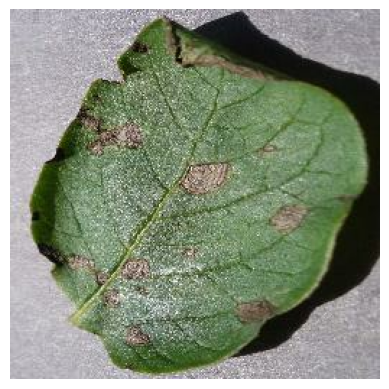

In [19]:
for batch_image, batch_label in train_ds.take(1):
    first_image = batch_image[0].numpy().astype('uint8')
    first_label = class_names[batch_label[0]]


    plt.imshow(first_image)
    print('Actual Label : ', first_label)

    batch_prediction = model.predict(batch_image)
    print('Predicted Label : ', class_names[np.argmax(batch_prediction[0])])
    plt.axis('off')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


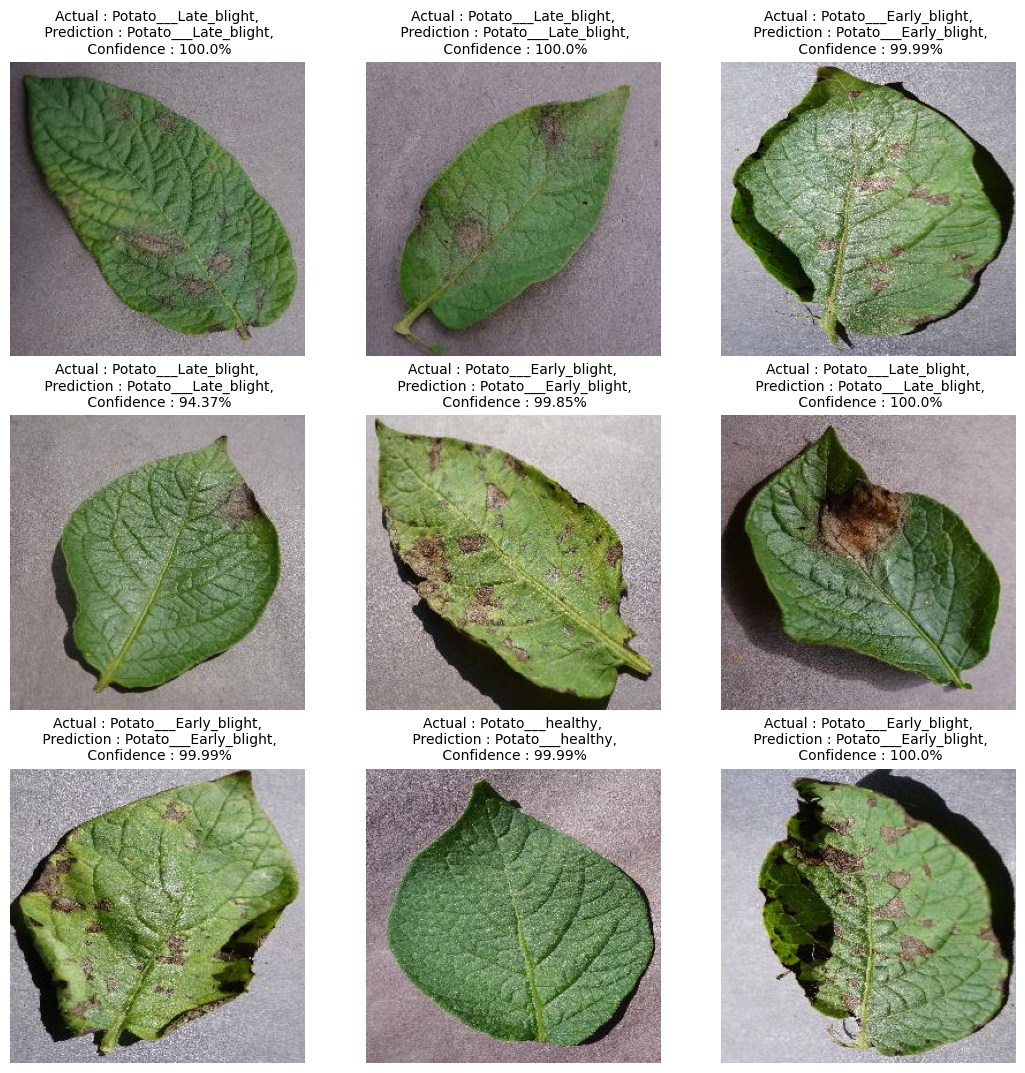

In [20]:
# plotting batch of images with its actual label, predicted label and confidence
plt.figure(figsize = (13,13))
for batch_image, batch_label in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        image = batch_image[i].numpy().astype('uint8')
        label = class_names[batch_label[i]]

        plt.imshow(image)

        batch_prediction = model.predict(batch_image)
        predicted_class = class_names[np.argmax(batch_prediction[i])]
        confidence = round(np.max(batch_prediction[i]) * 100, 2)

        plt.title(f'Actual : {label},\n Prediction : {predicted_class},\n Confidence : {confidence}%', fontsize=10)
        plt.axis('off')

> **Save the Model**

In [23]:
model.save("potato_disease_clf.keras")